Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

122/122 [==============================] - 81s 660ms/step - loss: 0.1560 - accuracy: 0.9618 - val_loss: 0.3332 - val_accuracy: 0.9167
Epoch 4/50
122/122 [==============================] - 77s 630ms/step - loss: 0.1576 - accuracy: 0.9601 - val_loss: 0.3328 - val_accuracy: 0.9185
Epoch 5/50
122/122 [==============================] - 77s 629ms/step - loss: 0.1567 - accuracy: 0.9565 - val_loss: 0.3333 - val_accuracy: 0.9161
Epoch 6/50
122/122 [==============================] - 77s 632ms/step - loss: 0.1513 - accuracy: 0.9591 - val_loss: 0.3216 - val_accuracy: 0.9256
Epoch 7/50
122/122 [==============================] - 79s 651ms/step - loss: 0.1343 - accuracy: 0.9633 - val_loss: 0.3265 - val_accuracy: 0.9179
Epoch 8/50
122/122 [==============================] - 78s 640ms/step - loss: 0.1274 - accuracy: 0.9700 - val_loss: 0.3247 - val_accuracy: 0.9286
Epoch 9/50
122/122 [==============================] - 78s 638ms/step - loss: 0.1374 - accuracy: 0.9632 - val_loss: 0.3218 - val_accuracy: 0.9

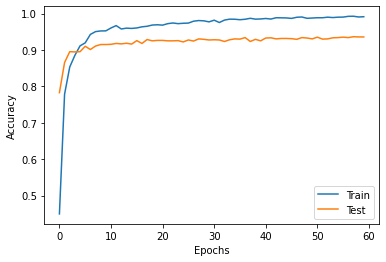

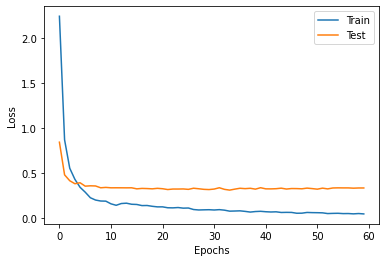

Text(0.5, 150.0, 'Predicted Class')

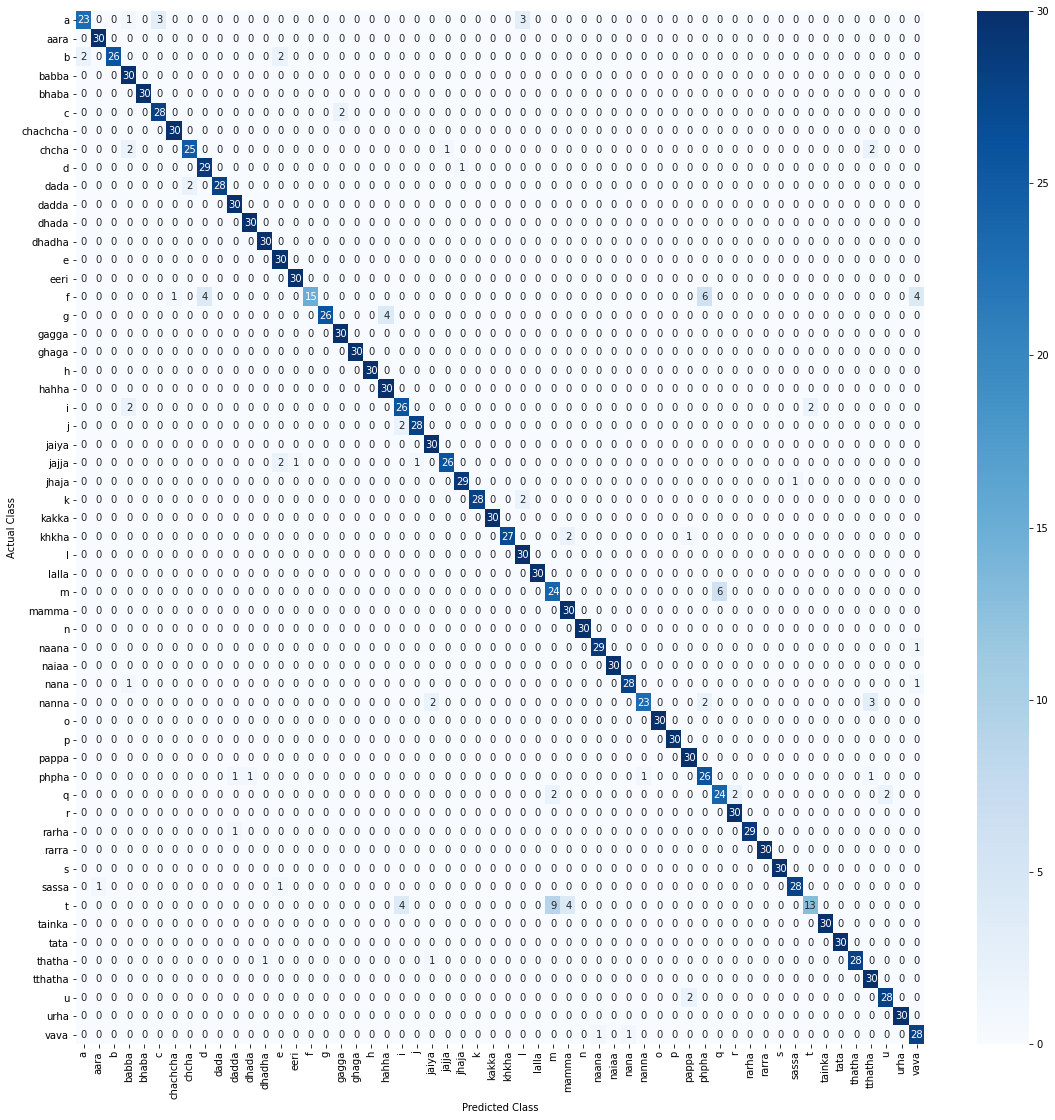

In [1]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/training_set/'
validation_data_dir = './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/testing_set/'
nb_train_samples = 3920
nb_validation_samples = 1680
num_classes = 56

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
            #         horizontal_flip=True,
                    fill_mode='constant',
                    cval = 0
                )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

In [2]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9398500124255048
recall_score   :  0.9357142857142858
f1_score       :  0.9332260313459503
accuracy_score :  0.9357142857142857

Best accuracy  :  0.9363095164299011


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

122/122 [==============================] - 74s 607ms/step - loss: 0.1602 - accuracy: 0.9577 - val_loss: 0.3442 - val_accuracy: 0.9101
Epoch 4/50
122/122 [==============================] - 73s 601ms/step - loss: 0.1463 - accuracy: 0.9617 - val_loss: 0.3431 - val_accuracy: 0.9119
Epoch 5/50
122/122 [==============================] - 75s 614ms/step - loss: 0.1462 - accuracy: 0.9576 - val_loss: 0.3427 - val_accuracy: 0.9113
Epoch 6/50
122/122 [==============================] - 74s 603ms/step - loss: 0.1461 - accuracy: 0.9673 - val_loss: 0.3310 - val_accuracy: 0.9143
Epoch 7/50
122/122 [==============================] - 74s 607ms/step - loss: 0.1382 - accuracy: 0.9686 - val_loss: 0.3382 - val_accuracy: 0.9149
Epoch 8/50
122/122 [==============================] - 75s 611ms/step - loss: 0.1401 - accuracy: 0.9655 - val_loss: 0.3321 - val_accuracy: 0.9125
Epoch 9/50
122/122 [==============================] - 74s 603ms/step - loss: 0.1314 - accuracy: 0.9665 - val_loss: 0.3327 - val_accuracy: 0.9

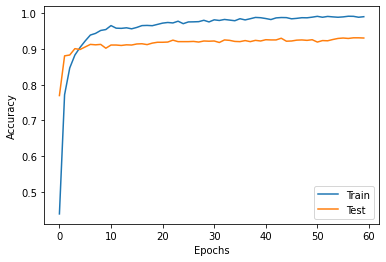

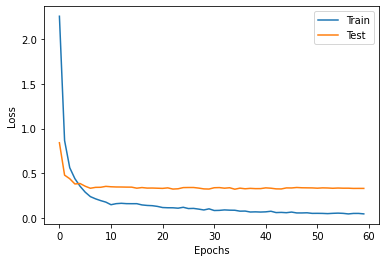

Text(0.5, 150.0, 'Predicted Class')

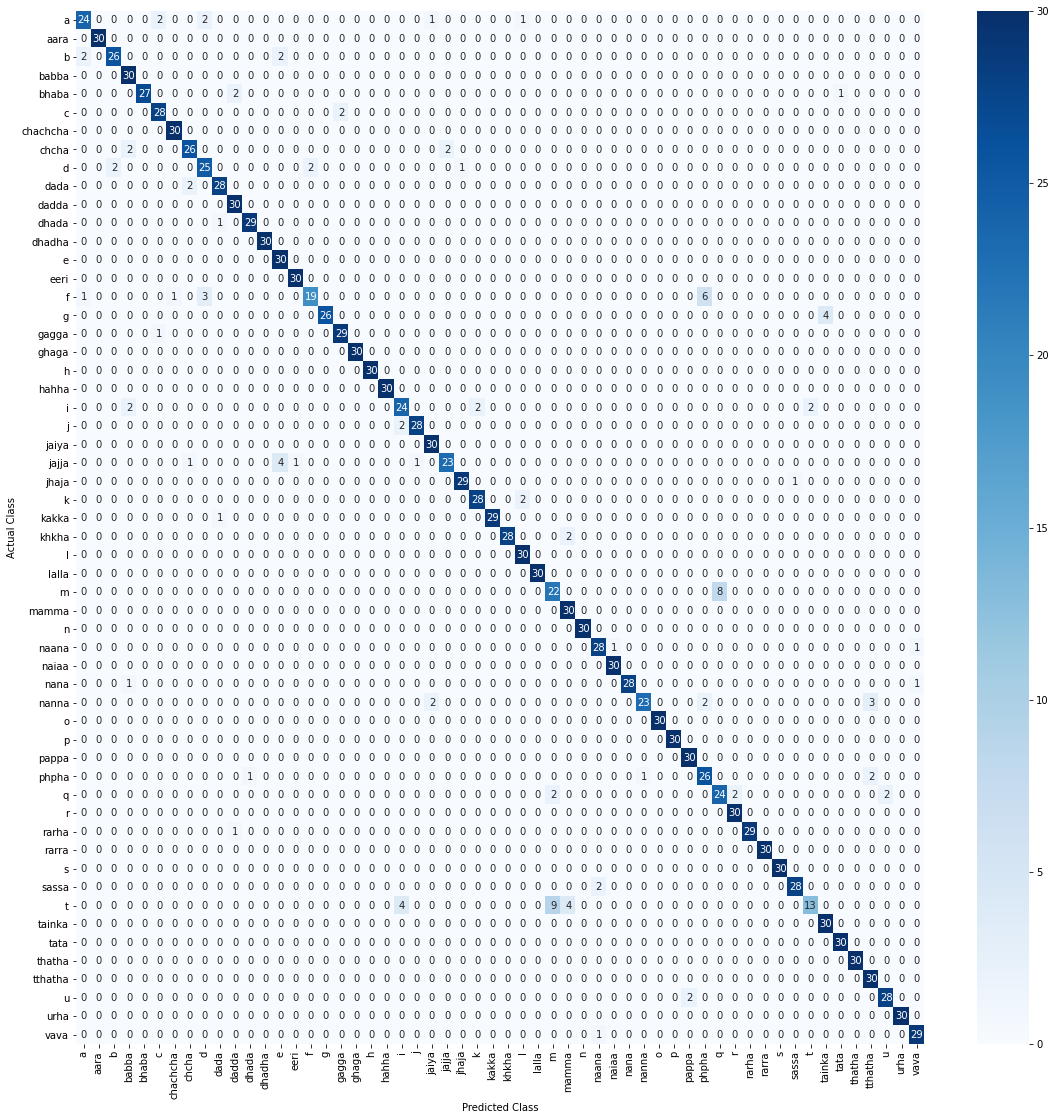

In [3]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/training_set/'
validation_data_dir = './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/testing_set/'
nb_train_samples = 3920
nb_validation_samples = 1680
num_classes = 56

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
            #         horizontal_flip=True,
                    fill_mode='constant',
                    cval = 0
                )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

In [4]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9331573712675146
recall_score   :  0.930952380952381
f1_score       :  0.9289437819679566
accuracy_score :  0.930952380952381

Best accuracy  :  0.9315476417541504


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

122/122 [==============================] - 76s 624ms/step - loss: 0.1538 - accuracy: 0.9640 - val_loss: 0.3457 - val_accuracy: 0.9220
Epoch 4/50
122/122 [==============================] - 76s 620ms/step - loss: 0.1506 - accuracy: 0.9564 - val_loss: 0.3452 - val_accuracy: 0.9220
Epoch 5/50
122/122 [==============================] - 75s 614ms/step - loss: 0.1424 - accuracy: 0.9655 - val_loss: 0.3455 - val_accuracy: 0.9220
Epoch 6/50
122/122 [==============================] - 76s 621ms/step - loss: 0.1459 - accuracy: 0.9623 - val_loss: 0.3332 - val_accuracy: 0.9196
Epoch 7/50
122/122 [==============================] - 76s 624ms/step - loss: 0.1347 - accuracy: 0.9681 - val_loss: 0.3473 - val_accuracy: 0.9214
Epoch 8/50
122/122 [==============================] - 77s 629ms/step - loss: 0.1199 - accuracy: 0.9744 - val_loss: 0.3442 - val_accuracy: 0.9220
Epoch 9/50
122/122 [==============================] - 76s 621ms/step - loss: 0.1301 - accuracy: 0.9650 - val_loss: 0.3376 - val_accuracy: 0.9

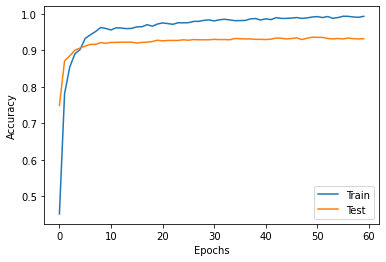

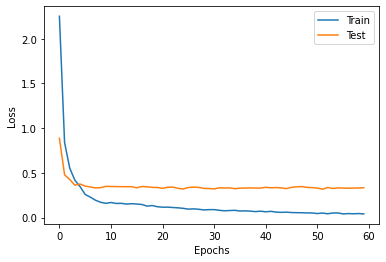

Text(0.5, 150.0, 'Predicted Class')

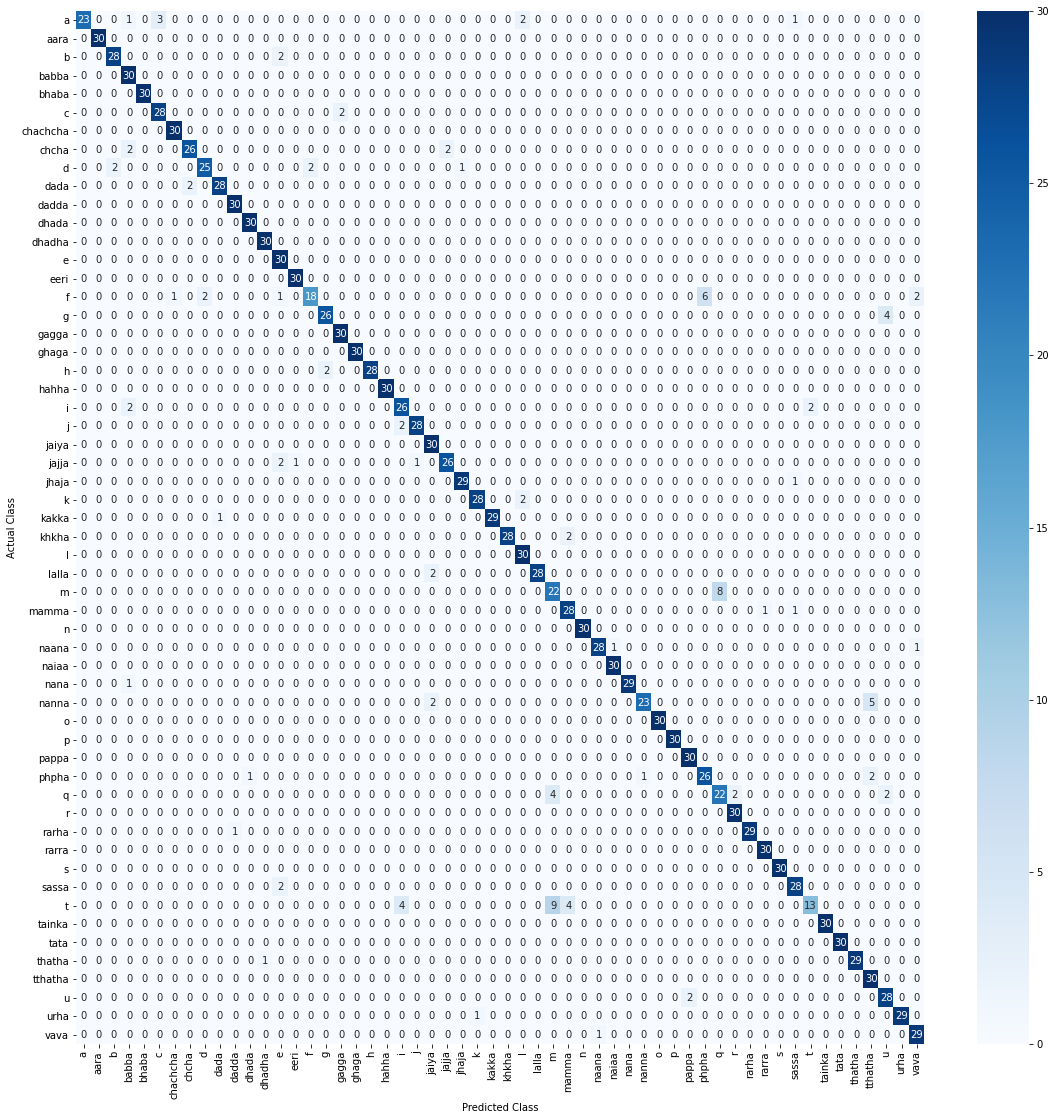

In [5]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/training_set/'
validation_data_dir = './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/testing_set/'
nb_train_samples = 3920
nb_validation_samples = 1680
num_classes = 56

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
            #         horizontal_flip=True,
                    fill_mode='constant',
                    cval = 0
                )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

In [6]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9348522993069616
recall_score   :  0.9315476190476192
f1_score       :  0.9297437686938155
accuracy_score :  0.9315476190476191

Best accuracy  :  0.9357143044471741


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

122/122 [==============================] - 76s 620ms/step - loss: 0.1434 - accuracy: 0.9587 - val_loss: 0.3261 - val_accuracy: 0.9131
Epoch 4/50
122/122 [==============================] - 76s 620ms/step - loss: 0.1630 - accuracy: 0.9545 - val_loss: 0.3264 - val_accuracy: 0.9143
Epoch 5/50
122/122 [==============================] - 78s 641ms/step - loss: 0.1502 - accuracy: 0.9608 - val_loss: 0.3272 - val_accuracy: 0.9143
Epoch 6/50
122/122 [==============================] - 76s 623ms/step - loss: 0.1557 - accuracy: 0.9630 - val_loss: 0.3128 - val_accuracy: 0.9208
Epoch 7/50
122/122 [==============================] - 76s 620ms/step - loss: 0.1402 - accuracy: 0.9630 - val_loss: 0.3105 - val_accuracy: 0.9196
Epoch 8/50
122/122 [==============================] - 75s 616ms/step - loss: 0.1458 - accuracy: 0.9635 - val_loss: 0.3187 - val_accuracy: 0.9179
Epoch 9/50
122/122 [==============================] - 75s 614ms/step - loss: 0.1223 - accuracy: 0.9729 - val_loss: 0.3167 - val_accuracy: 0.9

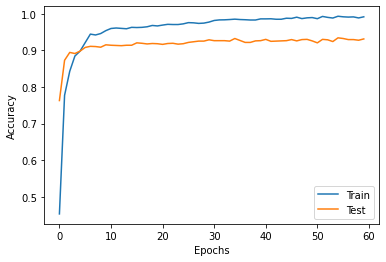

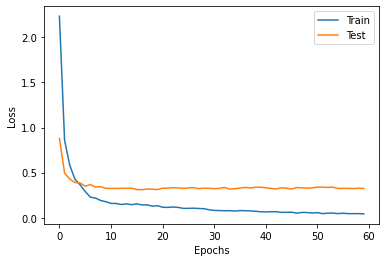

Text(0.5, 150.0, 'Predicted Class')

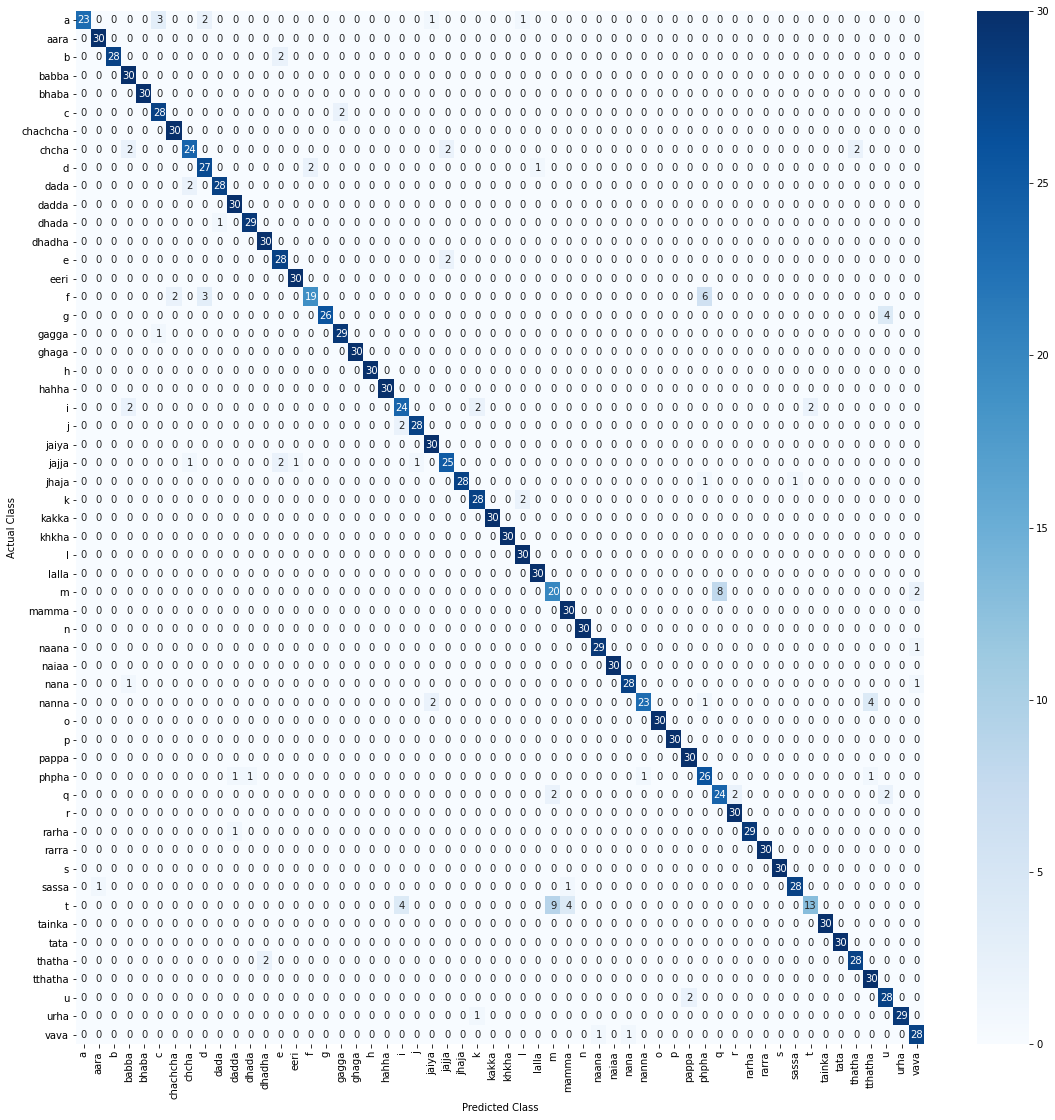

In [7]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/training_set/'
validation_data_dir = './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/testing_set/'
nb_train_samples = 3920
nb_validation_samples = 1680
num_classes = 56

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
            #         horizontal_flip=True,
                    fill_mode='constant',
                    cval = 0
                )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

In [8]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9335829973084558
recall_score   :  0.9315476190476192
f1_score       :  0.9294937576246832
accuracy_score :  0.9315476190476191

Best accuracy  :  0.9345238208770752


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

122/122 [==============================] - 95s 782ms/step - loss: 0.1488 - accuracy: 0.9654 - val_loss: 0.3510 - val_accuracy: 0.9185
Epoch 4/50
122/122 [==============================] - 92s 756ms/step - loss: 0.1381 - accuracy: 0.9684 - val_loss: 0.3498 - val_accuracy: 0.9185
Epoch 5/50
122/122 [==============================] - 87s 716ms/step - loss: 0.1553 - accuracy: 0.9602 - val_loss: 0.3491 - val_accuracy: 0.9185
Epoch 6/50
122/122 [==============================] - 96s 790ms/step - loss: 0.1531 - accuracy: 0.9610 - val_loss: 0.3424 - val_accuracy: 0.9214
Epoch 7/50
122/122 [==============================] - 105s 862ms/step - loss: 0.1569 - accuracy: 0.9617 - val_loss: 0.3411 - val_accuracy: 0.9173
Epoch 8/50
122/122 [==============================] - 97s 795ms/step - loss: 0.1397 - accuracy: 0.9647 - val_loss: 0.3409 - val_accuracy: 0.9226
Epoch 9/50
122/122 [==============================] - 116s 949ms/step - loss: 0.1367 - accuracy: 0.9684 - val_loss: 0.3380 - val_accuracy: 0

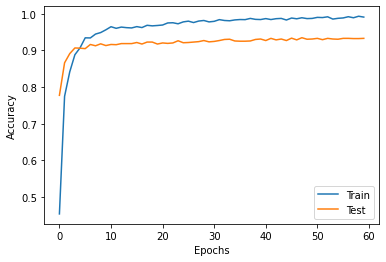

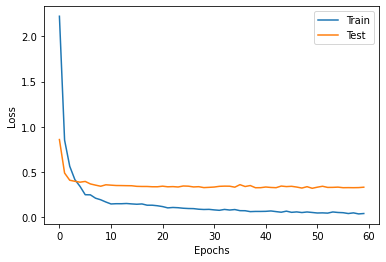

Text(0.5, 150.0, 'Predicted Class')

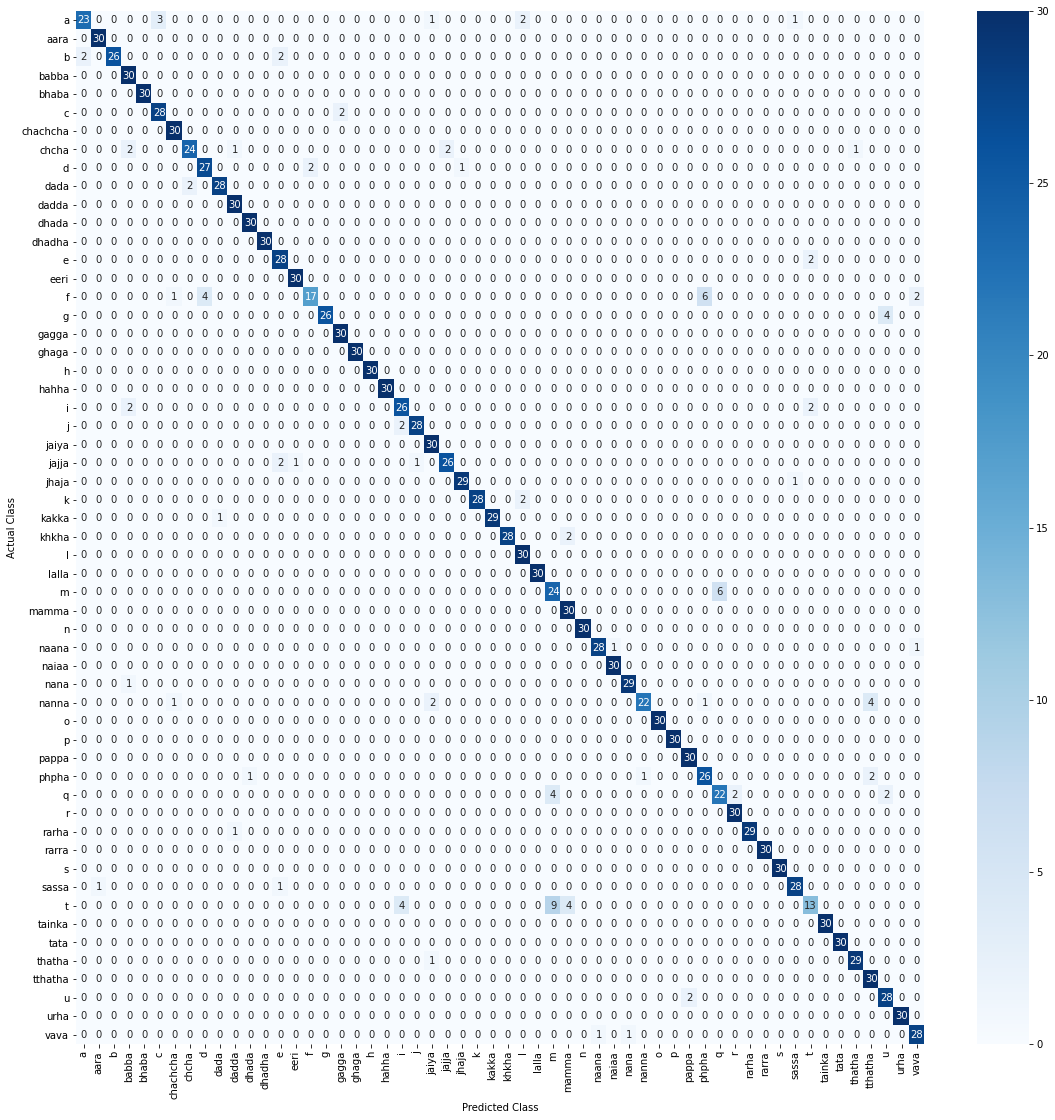

In [9]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir =      './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/training_set/'
validation_data_dir = './Data/Offline/Offline_Gurmukhi/Dataset/Images0/HWR-Gurmukhi__2.3/testing_set/'
nb_train_samples = 3920
nb_validation_samples = 1680
num_classes = 56

# learning params
epochs1 = 10
epochs2 = 50
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned50

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
            #         horizontal_flip=True,
                    fill_mode='constant',
                    cval = 0
                )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    shuffle=True,
    seed=13)
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    shuffle=False,
    class_mode='categorical')

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

In [10]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9347974349667176
recall_score   :  0.9327380952380953
f1_score       :  0.9306451079990118
accuracy_score :  0.9327380952380953

Best accuracy  :  0.9345238208770752
